<a href="https://colab.research.google.com/github/Abhijith-Nagarajan/PadhAI_Implementations/blob/main/FeedforwardNetwork_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing,model_selection, metrics, datasets
from tqdm import tqdm_notebook
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
target_classes = 5

In [ ]:
sample_data, labels = datasets.make_blobs(n_samples=10000,n_features=4,centers=target_classes)

In [ ]:
sample_data = np.array(sample_data)

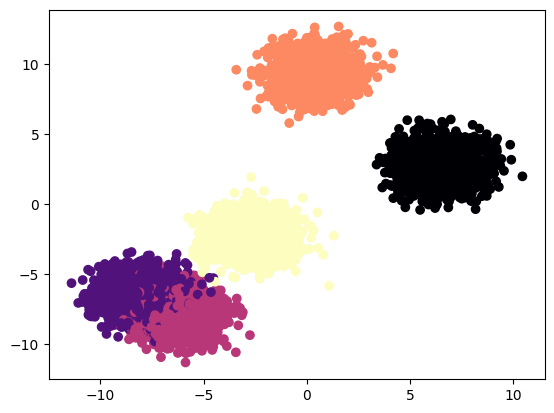

In [ ]:
plt.scatter(sample_data[:,0],sample_data[:,1],c=labels,cmap='magma')

In [ ]:
oh_encoder = preprocessing.OneHotEncoder()

In [ ]:
Y = oh_encoder.fit_transform(np.expand_dims(labels,1)).toarray()

In [ ]:
def NN_inputs():
    print('Inside NN inputs method')
    nn_layers = int(input("Enter the number of hidden layers: "))
    neurons_per_layer = [int(input(f"Enter neurons for hidden layer {i+1}: ")) for i in range(nn_layers)]

    return (nn_layers,neurons_per_layer)

In [ ]:
layers, neurons_per_layer = NN_inputs()

Inside NN inputs method
Enter the number of hidden layers: 3
Enter neurons for hidden layer 1: 3
Enter neurons for hidden layer 2: 4
Enter neurons for hidden layer 3: 3


### Testing


```
def w_b_test(layers: int, neurons_per_layer: list, input_shape: tuple target_classes: int):
    weights = []
    bias = []
    for layer in range(layers):
        m = input_shape[1] if layer==0 else neurons_per_layer[layer-1]
        weights.append(np.random.rand(neurons_per_layer[layer],m))
        bias.append(np.random.rand(input_shape[0],neurons_per_layer[layer]))

    m = neurons_per_layer[-1]
    weights.append(np.random.rand(target_classes,m))
    bias.append(np.random.rand(input_shape[0],target_classes))

    return (weights,bias)
```


```
w, b = w_b_test(layers,neurons_per_layer,sample_data.shape,target_classes)
```

```
A = []
H = []
```

```
def softmax_test(H):
    denominator = np.sum(np.exp(H),axis=1)
    #pdb.set_trace()
    probabilities = [np.round(np.exp(H[i])/denominator[i],2) for i in range(len(denominator))]
    return probabilities

def sigmoid_test(x):
    return 1.0/1.0+np.exp(-1*x)

def matrix_multiplication(X,w,b):
    return np.matmul(X,w.T)+b

def fit(X,w,b,layers):
    # For the hidden layers
    for i in range(layers):
        A.append(matrix_multiplication(X,w[i],b[i]) if i == 0 else matrix_multiplication(H[i-1],w[i],b[i]))
        H.append(sigmoid_test(A[i]))

    # For the last layer. Applying softmax operation to get probabilities
    A.append(matrix_multiplication(H[-1],w[-1],b[-1]))
    H.append(softmax_test(A[-1]))
    y_pred = H[-1]

    return y_pred
```

```
y_pred = fit(sample_data,w,b,layers)
```


```
metrics.log_loss(Y,y_pred)
```


Softmax debugging
```
a = np.array([[0.25,0.15,0.55,0.05],[0.6,0.05,0.25,0.1],[0.1,0.7,0.15,0.05],[0.3,0.1,0.1,0.5]])

numerator = np.exp(a)
numerator

denominator = np.sum(np.exp(a),axis=1)
denominator

print(numerator[index]/denominator[index] for index in range(len(denominator)))

for index in range(len(denominator)):
    print(np.round(numerator[index]/denominator[index],2))
```

### Feedforward class

In [ ]:
class FeedforwardNN:

    def __init__(self,layers,neurons_per_layer,input_shape,target_classes):
        print('Inside init method.')
        self.weights = []
        self.bias = []
        self.A = []
        self.H = []

        rows,features = input_shape

        # For hidden layers
        for layer in range(layers):
            m = features if layer==0 else neurons_per_layer[layer-1]
            self.weights.append(np.random.rand(neurons_per_layer[layer],m))
            self.bias.append(np.random.rand(rows,neurons_per_layer[layer]))

        # For output layer
        m = neurons_per_layer[-1]
        self.weights.append(np.random.rand(target_classes,m))
        self.bias.append(np.random.rand(rows,target_classes))
        print('Weights and Bias have been initialized.')

    def plot_loss_vs_epoch(self,loss:dict):
        plt.figure(figsize=(15,7))
        plt.plot(loss.keys(),loss.values())
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')

    def softmax_operation(self,a):
        exp_term = np.exp(a)
        return np.round((exp_term/np.sum(exp_term,axis=1)),2)

    def sigmoid_operation(self,a):
        return 1.0/(1.0+np.exp(-1*(a)))

    def backprop(self,X,Y,Y_pred,layers,learning_rate):
        '''
        This method performs back propagation to update W,B,A,H
        '''
        grad_a = Y_pred-Y
        for layer in range(layers,0,-1):
            grad_w = np.matmul(grad_a.T,self.H[layer-1])
            grad_b = grad_a
            self.weights[layer] -= learning_rate*grad_w
            self.bias[layer] -= learning_rate*grad_b
            grad_h = np.matmul(grad_a, self.weights[layer])
            # Grad a is computed as an element-wise multiplication of grad_h and derivative of the {[activation for 'a'] = H}  at the previous layer
            derivative_h = self.H[layer-1]
            grad_a = np.multiply(grad_h,derivative_h*(1-derivative_h))

        grad_w = np.matmul(grad_a.T,X)
        self.weights[0] -= learning_rate*grad_w
        self.bias[0] = grad_a

    def forward_pass(self,X,layers:int):
        '''
        This method performs the forward pass.
        '''
        for layer in range(layers):
            a = np.matmul(X,self.weights[layer].T)+self.bias[layer] if layer==0 else np.matmul(self.H[layer-1],self.weights[layer].T)+self.bias[layer]
            self.A.append(a)
            self.H.append(self.sigmoid_operation(a))

        a = np.matmul(self.H[-1],self.weights[-1].T)+self.bias[-1]
        self.A.append(a)
        self.H.append(self.softmax_operation(a))
        return self.H[-1]

    def fit(self,X,Y,epochs,layers,learning_rate):
        '''
        This method performs the training operation
        '''
        loss = dict()
        for epoch in tqdm_notebook(range(epochs),total=epochs,unit="epoch"):
            y_pred = self.forward_pass(X,layers)
            loss[epoch+1] = metrics.log_loss(Y,y_pred)
            self.backprop(X,Y,y_pred,layers,learning_rate)

        self.plot_loss_vs_epoch(loss)

    def predict(self,X):
        '''
        This method returns all the predictions on the test set
        '''

In [ ]:
ffmodel = FeedforwardNN(layers,neurons_per_layer,sample_data.shape,target_classes)

Inside init method.
Weights and Bias have been initialized.


In [ ]:
lr = 0.1
epochs = 100

  0%|          | 0/100 [00:00<?, ?epoch/s]

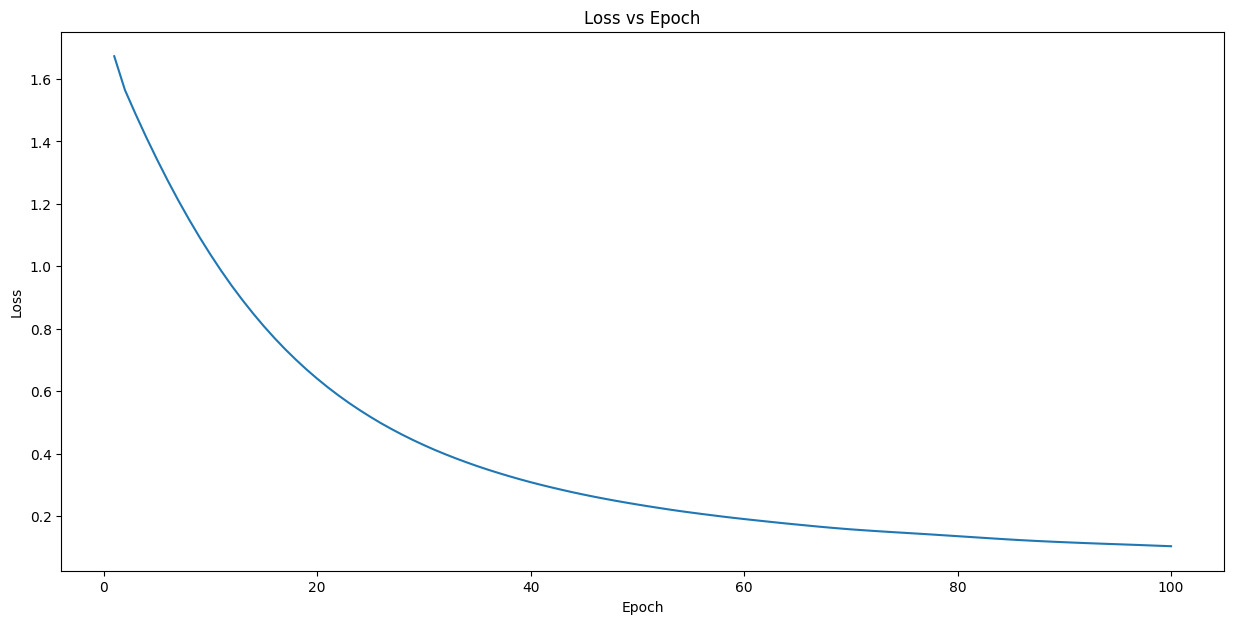

In [ ]:
ffmodel.fit(sample_data,Y,epochs,layers,lr)